# DA5401 Assignment 4
**GMM-Based Synthetic Sampling for Imbalanced Data**


Name: *Krithi Shailya* </br>
Roll Number: *DA25S009*


As discussed in the earlier notebook, class imbalance is a pervasive problem in many real-world datasets. In fraud detection (our case), the fraudulent transactions are extremely rare compared to legitimate transactions. A naive classifier can achieve very high accuracy by always predicting the majority class (non-fraud) but such a classifier is useless in practice. Traditional classification algorithms such as Logistic Regression, SVMs, or even Neural Networks are not inherently designed to cope with such skew. They tend to be biased towards the majority class because minimizing overall error implicitly favors the larger group.

While basic techniques like random oversampling (duplicating minority class samples), SMOTE, undersampling can help, they often lead to overfitting, where the model learns the specific details of the few fraudulent examples rather than the general patterns of fraudulent behavior.

**Objective**: This notebook tackles the challenge of class imbalance in a credit card fraud detection using a sophisticated oversampling technique using a Gaussian Mixture Model (GMM) to generate synthetic data points for the minority (fraudulent) class. The goal is to improve a classifier's ability to detect fraudulent transactions by providing it with a more balanced training set.

- **Establishing a Baseline**: We will first train a logistic regression model on the raw, imbalanced data. This will serve as our benchmark, revealing the limitations of a naive approach.

- **Implementing GMM-Based Oversampling**: We will then dive into the core of our solution, using a GMM to generate synthetic data for the fraudulent class and create a balanced training set.

- **Evaluating the Impact**: Finally, we will train a new model on our balanced dataset and compare its performance to our baseline. This will allow us to quantify the effectiveness of our GMM-based approach and draw clear, data-driven conclusions.


## Setup and imports

Before we begin our analysis, we need to set up our programming environment. This involves importing the necessary Python libraries that provide tools for data manipulation (pandas, numpy), visualization (matplotlib, seaborn), machine learning (scikit-learn), and specialized resampling techniques (Gaussion mixture). The following code cell ensures that all required packages are available for a smooth, reproducible workflow. We also setup some standard display settings for cleaner output and set a seed for producing reproducible results. 


In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, average_precision_score, precision_recall_curve
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

print('Libraries loaded')

# reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Display settings for nicer output
pd.set_option('display.max_columns', 200)
plt.rcParams['figure.figsize'] = (8,5)
sns.set_style('whitegrid')

Libraries loaded



## Part A: Baseline Model and Data Analysis

### 1. Data Loading and Initial Analysis

Here, we load the creditcard.csv dataset. This dataset is well-known for its severe class imbalance. Our first step is to load this data and take a look at its structure to confirm our understanding. 

This notebook expects the `creditcard.csv` dataset (the Kaggle Credit Card Fraud Detection dataset) in the same working directory as the project. If not found, the error block prompts the user to download it from the required source and place it in the folder. 



In [3]:
# Load the dataset
DATA_PATH = 'creditcard.csv'  # Ensure this file is in the same directory

# Check if the data file exists before trying to load it.
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(
        f"'{DATA_PATH}' not found. Please download the dataset from and place it in the folder"
    )

df = pd.read_csv(DATA_PATH)
print('Dataset loaded successfully.')
print('Shape of the dataset (rows, columns):', df.shape)
print('\nFirst 5 rows of the dataset:')
display(df.head())


Dataset loaded successfully.
Shape of the dataset (rows, columns): (284807, 31)

First 5 rows of the dataset:


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


We then perform an initial exploratory analysis. Our primary focus is to understand the distribution of the 'Class' variable, which tells us whether a transaction is fraudulent or not. 


Class Distribution:
Class
0    284315
1       492
Name: count, dtype: int64

Percentage of fraudulent transactions: 0.1727%


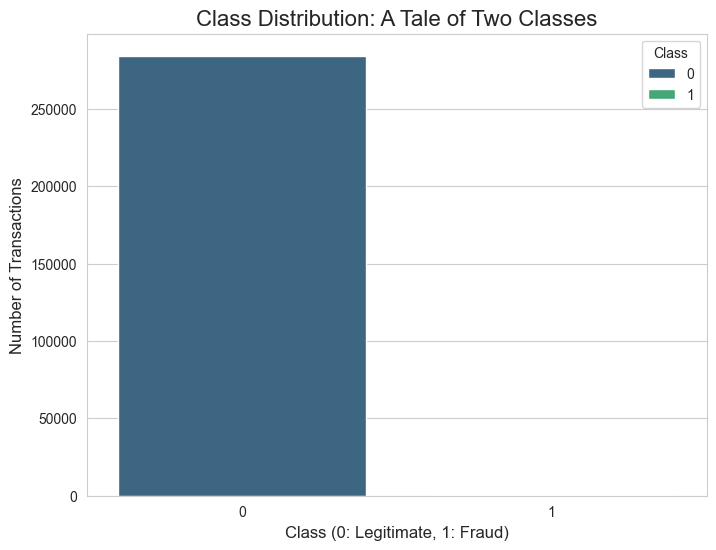

In [7]:

# --- Detailed Class Distribution Analysis ---
print("\nClass Distribution:")
class_distribution = df['Class'].value_counts()
fraud_percentage = (class_distribution[1] / class_distribution.sum()) * 100
print(class_distribution)
print(f"\nPercentage of fraudulent transactions: {fraud_percentage:.4f}%")

# Visualize the class imbalance
plt.figure(figsize=(8, 6))
sns.countplot(x='Class', data=df, palette='viridis', hue='Class')
plt.title('Class Distribution: A Tale of Two Classes', fontsize=16)
plt.xlabel('Class (0: Legitimate, 1: Fraud)', fontsize=12)
plt.ylabel('Number of Transactions', fontsize=12)


plt.show()


The above shows a highly imbalanced dataset with about 0.17% of fraud samples. Especially since fraud detection is the task at hand, models can paint a false picture of their overall accuracy by simple learning what is non fraud. If we train a model on this data, it will have very little information to learn the characteristics of fraudulent transactions. The overwhelming number of legitimate transactions will dominate the learning process, leading the model to be extremely biased. Or even worse, even if the model labels everything as non-fraud (practically useless), It will still be 99.8+% accurate, which is a completely misleading number for the task at hand. This highlights the need for class balanced clustering and learning with the right use of metrics for measuring the efficiency.

### 2) Data Preprocessing and Splitting

The dataset's features are mostly principal components from a PCA transformation, but the 'Time' and 'Amount' features are in their original scale. We'll scale the 'Amount' and 'Time' to bring it in line with the other features. We will use StandardScaler to scale these two features. Importantly, we fit the scaler only on the training data and then use that same fitted scaler to transform both the training and test data. This prevents "data leakage" from the test set into our training process. 


We then split our data. It is absolutely critical that the test set remains a pristine, untouched reflection of the real world—meaning it must keep its original, imbalanced distribution. Our model must ultimately prove its worth on realistic data.We split the dataset into training and testing sets while preserving the original imbalance in the test set. The test set must not be rebalanced. We'll use a stratified split to keep the same class proportions.


In [8]:
# Define features (X) and target (y)
X = df.drop(columns=['Class'])
y = df['Class']

# Split the data into training and testing sets, preserving the class distribution
# Choosing a bigger test size to ensure enough fraud cases in the test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=RANDOM_STATE)

print('Data Splitting')
print('Training set shape:', X_train.shape)
print('Test set shape:', X_test.shape)
print('\nFraud percentage in training set:', f"{y_train.mean()*100:.4f}%")
print('Fraud percentage in test set:', f"{y_test.mean()*100:.4f}%")

# Preprocessing: Scale the 'Time' and 'Amount' columns
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# Scale 'Time' and 'Amount'
cols_to_scale = ['Time', 'Amount']
X_train_scaled[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_test_scaled[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

display(X_train_scaled.head())

Data Splitting
Training set shape: (199364, 30)
Test set shape: (85443, 30)

Fraud percentage in training set: 0.1725%
Fraud percentage in test set: 0.1732%


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
249927,1.257992,-0.012102,0.707332,0.163334,-0.756498,0.590999,-0.653429,0.844608,-0.001672,-0.184399,-0.222719,0.377643,0.386075,-0.650025,0.418040,-1.009056,0.225934,-0.738861,-0.068285,0.329703,-0.038329,-0.231385,-0.572415,0.042660,-0.360882,-0.494703,0.142657,0.235922,0.083758,-0.321082
214082,0.939713,1.776151,-0.184642,-2.204096,1.191668,0.614461,-1.016525,0.919254,-0.387465,-0.318277,0.517022,0.489890,0.247935,-1.055373,1.242616,-0.433066,-0.136620,-0.720880,0.328234,-0.016297,-0.030437,0.281190,0.530070,-0.232262,-0.342096,0.492355,-0.427682,-0.075228,-0.056755,0.243475
106005,-0.528960,-1.083391,-4.440527,-1.399530,0.469764,-2.076458,-0.766137,1.601441,-0.709176,-1.288745,0.086419,-0.376936,0.191335,1.046362,0.420874,0.805190,-1.316514,0.059491,0.915477,-1.087435,2.189260,0.346463,-1.432833,-1.097063,0.505926,-0.140185,0.870190,-0.316982,0.227833,4.797594
58619,-0.977583,-0.518847,1.025087,-0.614624,-0.780959,2.474666,3.335055,0.046111,0.794249,-0.322448,0.128383,0.009338,-0.341516,0.004210,-0.287098,1.385535,0.398955,-0.299877,0.403600,0.929925,0.225957,-0.193099,-0.708348,0.145672,0.944217,-0.788017,0.039995,0.010804,0.254309,-0.331514
191638,0.725456,-0.640421,0.212171,0.283341,-1.786916,2.616127,4.024863,-0.198897,0.937087,0.474428,-0.283699,-0.331548,-0.180028,-0.254641,-0.388456,0.414223,0.048084,-0.710405,0.007241,-0.458141,0.154309,0.167939,0.759218,-0.321412,0.767971,-0.084221,0.612936,0.074029,-0.033344,-0.331514


### 3) Baseline Evaluation

Now, we train our baseline Logistic Regression model on the imbalanced training data. This will show us the performance we can expect without any special techniques. Its performance will serve as the benchmark against which we will measure all subsequent models. We expect this model to perform poorly in identifying fraud (i.e., have low recall) because it will be heavily biased towards the majority (non-fraud) class.

We will evaluate the model using a classification report, which provides precision, recall, and F1-score for each class. We will also compute the Average Precision (AUPRC), which is a robust metric for imbalanced datasets that summarizes the trade-off between precision and recall across different probability thresholds. A Precision-Recall curve will visualize this trade-off.


Training Baseline Model


Baseline model trained.

 Baseline Model Evaluation
Classification Report (Baseline):
                precision    recall  f1-score   support

Legitimate (0)     0.9993    0.9998    0.9996     85295
     Fraud (1)     0.8585    0.6149    0.7165       148

      accuracy                         0.9992     85443
     macro avg     0.9289    0.8073    0.8581     85443
  weighted avg     0.9991    0.9992    0.9991     85443

Average Precision-Recall Score (AUPRC): 0.7080


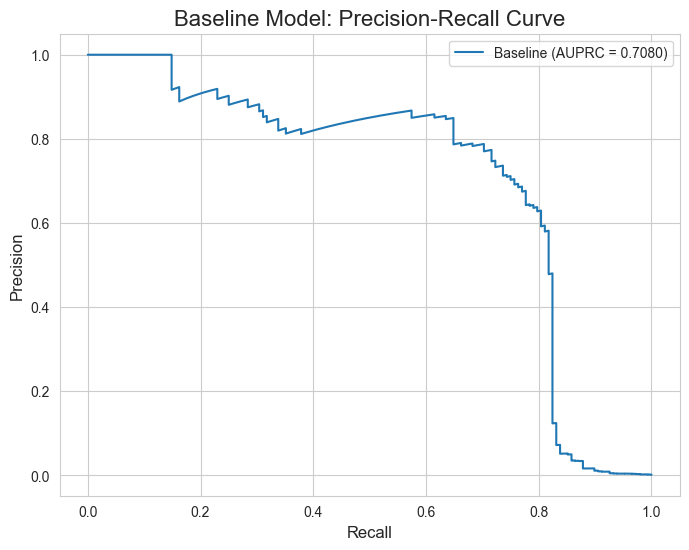

In [9]:
# Baseline Logistic Regression
print('Training Baseline Model')
clf_baseline = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
clf_baseline.fit(X_train_scaled, y_train)
print('Baseline model trained.')

# Predictions on the imbalanced test set
y_pred_baseline = clf_baseline.predict(X_test_scaled)
y_score_baseline = clf_baseline.predict_proba(X_test_scaled)[:, 1]

# Evaluation
print('\n Baseline Model Evaluation')
print('Classification Report (Baseline):')
print(classification_report(y_test, y_pred_baseline, digits=4, target_names=['Legitimate (0)', 'Fraud (1)']))

ap_baseline = average_precision_score(y_test, y_score_baseline)
print(f'Average Precision-Recall Score (AUPRC): {ap_baseline:.4f}')

# Plotting the Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_score_baseline)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Baseline (AUPRC = {ap_baseline:.4f})')
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Baseline Model: Precision-Recall Curve', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

**Why Precision, Recall, and F1-Score?**
In imbalanced classification, accuracy is a misleading estimat and a model that predicts "not fraud" every time would have over 99.8% accuracy but would be completely useless. We need more nuanced metrics:

- Recall (or Sensitivity): This is our most critical metric. It answers the question: "Of all the actual fraudulent transactions, what percentage did we correctly identify?" High recall is paramount because missing a fraudulent transaction (a false negative) is very costly.

- Precision: This metric answers: "Of all the transactions we flagged as fraudulent, what percentage were actually fraudulent?" High precision is also important to avoid bothering customers with false alarms (false positives).

- F1-Score: This is the harmonic mean of precision and recall, providing a single score that balances both concerns.

As expected, the baseline model achieves high precision but very low recall for the fraud class. This means that when it predicts fraud, it's often correct, but it misses a significant portion of actual fraudulent transactions. The low F1-score for the fraud class (a harmonic mean of precision and recall) confirms its poor overall performance on the minority class. Our goal with resampling is to drastically improve this recall and F1-score. It means that our baseline model is failing to detect almost 40% of fraudulent transactions. For a financial institution, this translates to huge potential losses and a significant security gap. This poor performance is our primary motivation for moving to a more sophisticated approach. We have now established a clear, quantifiable need for a better strategy.


## Part B: Gaussian Mixture Model (GMM) for Synthetic Sampling

### 1) Theoretical Foundations

The most widely used synthetic oversampling technique is **SMOTE (Synthetic Minority Over-sampling Technique)** as the idea behind it is simple yet powerful. The whole goal is to take a minority point, identify one of its k-nearest neighbors from the minority class and generate a new synthetic point somewhere along the straight line connecting the two points. This approach is simple and effective for many datasets, but it has limitations. 

- By restricting synthetic samples to lie along straight lines, SMOTE assumes that the minority class distribution is roughly linear and convex. In reality, minority data may form irregular or multimodal clusters.  
- If minority points are noisy or located near the boundary with the majority class, SMOTE will generate synthetic points in precisely those risky regions, making the classifier more confused rather than more accurate.
- SMOTE does not explicitly model subpopulations within the minority class. For example, fraudulent transactions may come from multiple distinct fraud strategies. SMOTE will blur them together instead of respecting their multimodal structure

**GMM-based sampling** models a probabilistic model that represents data as a weighted mixture of multiple Gaussian distributions. Each Gaussian component is characterized by a mean vector and a covariance matrix, capturing not only the center of a cluster but also its spread and correlations among features. The overall model is trained using the Expectation-Maximization (EM) algorithm, which iteratively estimates both the component parameters and the membership probabilities of each data point.

When applied to minority class data:
- A GMM can discover sub-clusters within the minority class (e.g., different fraud strategies). Each sub-cluster is modeled with its own covariance structure, meaning synthetic points can capture realistic dependencies between features.
- Synthetic samples are generated by sampling directly from the fitted mixture distribution, ensuring they follow the probability contours of the real minority class rather than arbitrary linear interpolations.
- Low-likelihood (outlying) minority instances can be identified and downweighted or filtered when fitting/sampling. Several recent works propose GMM-based oversampling improvements (e.g., G-SMOTE / GMOTE) and report improved performance. 

When the minority class is multimodal, has subgroups, or complex covariance patterns, GMM solves a lot of problems that regular SMOTE fails to. If the minority class is roughly unimodal and linear, SMOTE will often be simpler and competitive.


### 2) Gausian Mixture Model Implementation

We will now build our synthetic data generator pipeline using GMM. Given that in the previous assignment, we observed multiple different clusters and subgroups of our fraud class, the objective is to identify if GMM can appropriately model and capture all these nuances in the data distribution. 

**Isolate the Minority Class**

Our goal is to generate synthetic fraudulent transactions. Therefore, our GMM must learn exclusively from the examples of fraud we already have. We isolate these from our training set to ensure the model isn't contaminated by the patterns of legitimate transactions and focuses solely on the characteristics of fraud. 

In [10]:
# Separate the minority class data (fraudulent transactions)
X_train_minority = X_train_scaled[y_train == 1]
y_train_minority = y_train[y_train == 1]
print(f"Isolating the {X_train_minority.shape[0]} fraudulent transactions from the training set to train GMM.")

Isolating the 344 fraudulent transactions from the training set to train GMM.


**Finding the Optimal Number Gaussian Distributions**

A crucial component is determining how many Gaussian distributions to use. This is the `n_components` hyperparameter, k. If k is too low, our model will be too simple and fail to capture the different types of fraud (underfitting). If k is too high, our model might become overly complex, essentially "memorizing" the training data by fitting a component to every small group of points (overfitting).

To make an informed decision, we use statistical tools: the Akaike Information Criterion (AIC) and the Bayesian Information Criterion (BIC). Both are measures that seek a balance between:

- Goodness of Fit: How well the model explains the data.
- Model Simplicity: Penalizing the model for having too many parameters (i.e., too many components).

We will calculate the AIC and BIC for a range of k values and look for the "elbow point"—the point where adding more components provides diminishing returns and the score begins to flatten out. The BIC is often preferred as it applies a stronger penalty for complexity.


The optimal number of components that minimizes the BIC score is: 5


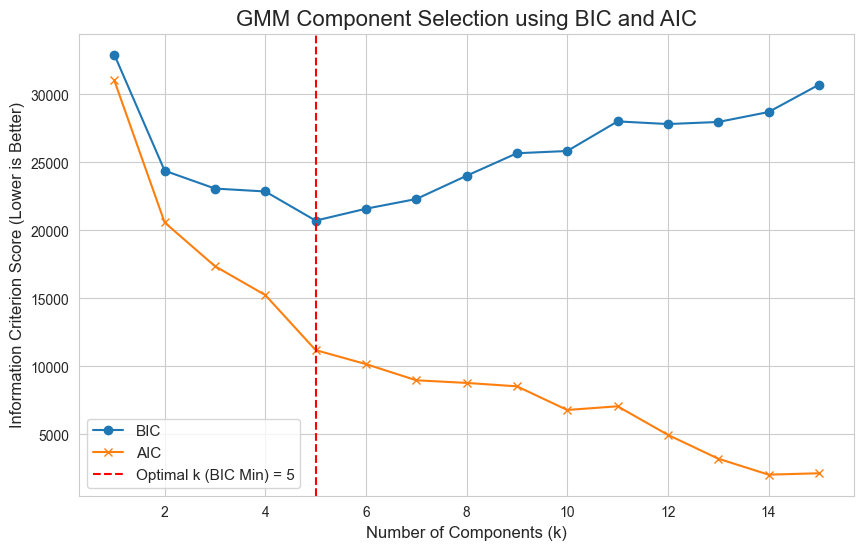

In [11]:
import warnings
warnings.filterwarnings('ignore')

# testing a range of 'k' values to find the sweet spot between model complexity and goodness of fit.
n_components = np.arange(1, 16)
models = [GaussianMixture(n, covariance_type='full', random_state=42).fit(X_train_minority) for n in n_components]

bics=[m.bic(X_train_minority) for m in models]
optimal_k = n_components[np.argmin(bics)]

print(f"The optimal number of components that minimizes the BIC score is: {optimal_k}")

# Plotting the BIC and AIC scores to visually identify the 'elbow'.
plt.figure(figsize=(10, 6))
plt.plot(n_components, [m.bic(X_train_minority) for m in models], label='BIC', marker='o')
plt.plot(n_components, [m.aic(X_train_minority) for m in models], label='AIC', marker='x')
plt.title('GMM Component Selection using BIC and AIC', fontsize=16)
plt.xlabel('Number of Components (k)', fontsize=12)
plt.ylabel('Information Criterion Score (Lower is Better)', fontsize=12)
plt.legend()
plt.grid(True)

plt.axvline(x=optimal_k, color='r', linestyle='--',
            label=f'Optimal k (BIC Min) = {optimal_k}')
# We need to re-call legend() to include the axvline label
plt.legend(fontsize=11)


plt.show()

From the curve, both scores drop sharply at the beginning, indicating that a model with 3 components is much better than a model with 1. The scores continue to decrease, but the rate of decrease slows down. The BIC curve, in particular, begins to form an "elbow" and increase after k=5, which indicates that the complexity does not balance the optimization after this To balance performance and avoid overfitting, we'll select k=5 as our optimal number of components. This implies our GMM has hypothesized that the fraudulent transactions can be best described as a mixture of 5 distinct underlying distributions.

**Training and Generation**: 
We will instantiate our GMM with k=5 and train it on our isolated fraud data. The .fit() method is where the Expectation-Maximization algorithm runs its iterative process to learn the optimal parameters (means, covariances, and weights) of our 5 Gaussian components.

Once the model is trained, it holds a complete, probabilistic understanding of the fraud data. We can then use the .sample() method to ask the model to generate new data points. This is the generative step. The model will randomly sample from the 5 Gaussian distributions it has learned, according to their learned mixing proportions, to create brand new, entirely synthetic data points that are statistically consistent with the original fraud data.

In [12]:

n_majority = y_train.value_counts()[0]
n_minority = y_train.value_counts()[1]
print('Training majority:', n_majority, 'Training minority:', n_minority)

# number of synthetic samples to generate to equal majority
n_synthetic_samples = n_majority - n_minority
print('Synthetic samples to generate (to match majority):', n_synthetic_samples)

# Train GMM with the selected number of components (k=5)
gmm = GaussianMixture(n_components=5, covariance_type='full', random_state=42)
gmm.fit(X_train_minority)

# Draw samples from the selected GMM
X_synthetic, _ = gmm.sample(n_samples=n_synthetic_samples)
print('Sampled shape:', X_synthetic.shape)
y_synthetic = np.ones(n_synthetic_samples, dtype=int)

print(f"Successfully generated {len(X_synthetic)} new synthetic fraud samples.")

Training majority: 199020 Training minority: 344
Synthetic samples to generate (to match majority): 198676
Sampled shape: (198676, 30)
Successfully generated 198676 new synthetic fraud samples.


**Assembling the Final, Balanced Dataset**

The final step is to combine our original training data (which includes the original majority and minority samples) with our newly synthesized minority samples. This creates a new, perfectly balanced training set, ready to train a much more robust and unbiased classifier.

In [13]:

# Combine the original X_train and y_train with our new synthetic data.
# np.vstack and np.hstack are used to stack the arrays vertically and horizontally, respectively.
X_train_balanced = np.vstack((X_train_scaled.values, X_synthetic))
y_train_balanced = np.hstack((y_train.values, y_synthetic))

# New class distribution.
print("\n--- Final Balanced Training Set ---")
print("Shape of balanced features:", X_train_balanced.shape)
print("Shape of balanced target:", y_train_balanced.shape)
print("\nNew class distribution:")
print(pd.Series(y_train_balanced).value_counts())


--- Final Balanced Training Set ---
Shape of balanced features: (398040, 30)
Shape of balanced target: (398040,)

New class distribution:
0    199020
1    199020
Name: count, dtype: int64


This engineers a balanced dataset. By going through this model-based process, we have given the minority class a balanced representation by teaching our model different groups of what fraud can look like. 

### Rebalancing with Clustering-Based Undersampling (CBU)

The above approach oversamples the minority class. While this might also be effective, another approach involves bringing down/undersampling the majority class to a more realistic estimate and then oversampling the minority class. The majority class (legitimate transactions) contains a lot of redundant information. Many data points are very similar to each other. By simply training on all of them, we force our model to spend a lot of effort learning patterns from very similar examples, and we risk the model's decision boundary being overly influenced by the sheer volume of these points.

Clustering-Based Undersampling (CBU) is a way to reduce the size of the majority class without losing its essential characteristics. The idea is to group the majority class samples into clusters using an algorithm like K-Means. Instead of keeping all the points, we can keep only the points that are most representative of each cluster. We'll use K-Means to partition the majority class data into a fixed number of clusters (e.g., 20). Each cluster will represent a different type of a legitimate transaction.

This gives us a smaller, but still representative, dataset for the majority class. It's like creating a high-quality summary of the original data. We will first undersample the majority class, and then use our GMM to generate enough synthetic minority samples to match this new, smaller majority population.

In [14]:
# Isolate the majority class from the original training set
X_train_majority = X_train_scaled[y_train == 0]
y_train_majority = y_train[y_train == 0]

# Define the number of clusters to represent different transaction archetypes
n_clusters = 20

# Use K-Means to find the cluster archetypes
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
kmeans.fit(X_train_majority)


KMeans(n_clusters=20, n_init=10, random_state=42)

In [15]:
# The final desired size of the undersampled majority class
target_majority_size = n_minority * 10 
points_per_cluster = target_majority_size // n_clusters

undersampled_indices = []
for i in range(n_clusters):
    # Get all points belonging to the current cluster
    cluster_points_indices = np.where(kmeans.labels_ == i)[0]
    cluster_points = X_train_majority.iloc[cluster_points_indices]
    
    # Get the centroid for the current cluster
    centroid = kmeans.cluster_centers_[i]
    
    # Calculate the distance of each point in the cluster to the centroid
    distances = np.sum((cluster_points - centroid)**2, axis=1)
    
    # Get the indices of the 'points_per_cluster' closest points
    closest_indices_in_cluster = np.argsort(distances)[:points_per_cluster]
    
    # Get their original indices from the dataframe
    original_indices = cluster_points.index[closest_indices_in_cluster]
    undersampled_indices.extend(original_indices)

# Create the new undersampled majority dataset
X_train_majority_undersampled = X_train_scaled.loc[undersampled_indices]
y_train_majority_undersampled = y_train.loc[undersampled_indices]

print("Shape of new undersampled majority features:", X_train_majority_undersampled.shape)

Shape of new undersampled majority features: (3331, 30)


**Create the Final Hybrid-ReBalanced Dataset**

The final step is to use our GMM to generate synthetic minority samples to match our new undersampled majority population.

In [16]:
# Use the GMM to generate synthetic samples to match the new majority size
n_synthetic_hybrid = len(y_train_majority_undersampled) - n_minority
X_synthetic_hybrid, _ = gmm.sample(n_samples=n_synthetic_hybrid)
y_synthetic_hybrid = np.ones(n_synthetic_hybrid, dtype=int)

# Combine the undersampled majority with the synthetic minority
X_train_hybrid = np.vstack((X_train_majority_undersampled.values, X_train_minority.values, X_synthetic_hybrid))
y_train_hybrid = np.hstack((y_train_majority_undersampled.values, y_train_minority.values, y_synthetic_hybrid))

print("\nShape of the hybrid-balanced training features:", X_train_hybrid.shape)
print("Shape of the hybrid-balanced training target:", y_train_hybrid.shape)
print("\nNew class distribution of the hybrid-balanced training set:")
print(pd.Series(y_train_hybrid).value_counts())



Shape of the hybrid-balanced training features: (6662, 30)
Shape of the hybrid-balanced training target: (6662,)

New class distribution of the hybrid-balanced training set:
0    3331
1    3331
Name: count, dtype: int64


## Part C: Performance Evaluation and Conclusion

We will now train classifiers on our two different balanced datasets (GMM Oversampling Only, and the new Hybrid) and compare them against our baseline. We will w look at the metrics and dissect them to understand the real-world implications of each model's behavior

### 1) Model Training on Balanced Datasets

We will train two new Logistic Regression models: one on the purely oversampled data and one on our hybrid (CBU and GMM) rebalanced data.


In [17]:
# Model 2: Trained on GMM Oversampling Only Data
gmm_model_oversample = LogisticRegression(random_state=42, max_iter=1000)
gmm_model_oversample.fit(X_train_balanced, y_train_balanced)
y_pred_oversample = gmm_model_oversample.predict(X_test_scaled)

# Model 3 (Revised): Trained on Advanced Hybrid CBU + GMM Data
gmm_model_hybrid_adv = LogisticRegression(random_state=42, max_iter=1000)
gmm_model_hybrid_adv.fit(X_train_hybrid, y_train_hybrid)
y_pred_hybrid_adv = gmm_model_hybrid_adv.predict(X_test_scaled)

print("Models have been trained successfully.")

Models have been trained successfully.


### Model Evaluation and Analyis

Let's evaluate and compare all three models. We will look at the classification reports, but more importantly, we will visualize and interpret their confusion matrices. A confusion matrix gives us a detailed breakdown of a model's successes and failures.



In [18]:
# Store all metrics for comparison
metrics_data = {
    'Baseline': {
        'Precision': precision_score(y_test, y_pred_baseline),
        'Recall': recall_score(y_test, y_pred_baseline),
        'F1-Score': f1_score(y_test, y_pred_baseline)
    },
    'GMM Oversampling Only': {
        'Precision': precision_score(y_test, y_pred_oversample),
        'Recall': recall_score(y_test, y_pred_oversample),
        'F1-Score': f1_score(y_test, y_pred_oversample)
    },
    'Hybrid (CBU + GMM)': {
        'Precision': precision_score(y_test, y_pred_hybrid_adv),
        'Recall': recall_score(y_test, y_pred_hybrid_adv),
        'F1-Score': f1_score(y_test, y_pred_hybrid_adv)
    }
}
comparison_df = pd.DataFrame(metrics_data)

print("\nSummary Metrics Table")
display(comparison_df)



Summary Metrics Table


,Baseline,GMM Oversampling Only,Hybrid (CBU + GMM)
Precision,0.858491,0.086420,0.022486
Recall,0.614865,0.851351,0.871622
F1-Score,0.716535,0.156912,0.043840


In [19]:
target_names = ['Legitimate (Class 0)', 'Fraud (Class 1)']

print("Baseline Model")
print(classification_report(y_test, y_pred_baseline, target_names=target_names))
print("-"*50 + "\n")

print("GMM Oversampling Only Model")
print(classification_report(y_test, y_pred_oversample, target_names=target_names))
print("-"*50 + "\n")

print("Hybrid (CBU + GMM) Model")
print(classification_report(y_test, y_pred_hybrid_adv, target_names=target_names))
print("="*50 + "\n")

Baseline Model
                      precision    recall  f1-score   support

Legitimate (Class 0)       1.00      1.00      1.00     85295
     Fraud (Class 1)       0.86      0.61      0.72       148

            accuracy                           1.00     85443
           macro avg       0.93      0.81      0.86     85443
        weighted avg       1.00      1.00      1.00     85443

--------------------------------------------------

GMM Oversampling Only Model
                      precision    recall  f1-score   support

Legitimate (Class 0)       1.00      0.98      0.99     85295
     Fraud (Class 1)       0.09      0.85      0.16       148

            accuracy                           0.98     85443
           macro avg       0.54      0.92      0.57     85443
        weighted avg       1.00      0.98      0.99     85443

--------------------------------------------------

Hybrid (CBU + GMM) Model
                      precision    recall  f1-score   support

Legitimate (Cla

<Figure size 1000x700 with 0 Axes>

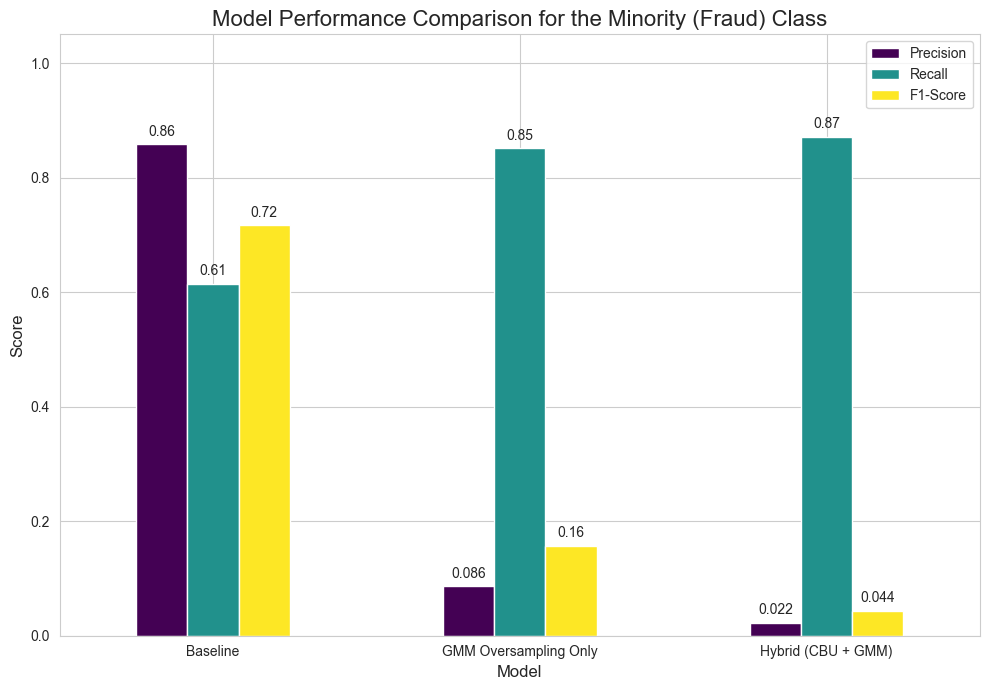

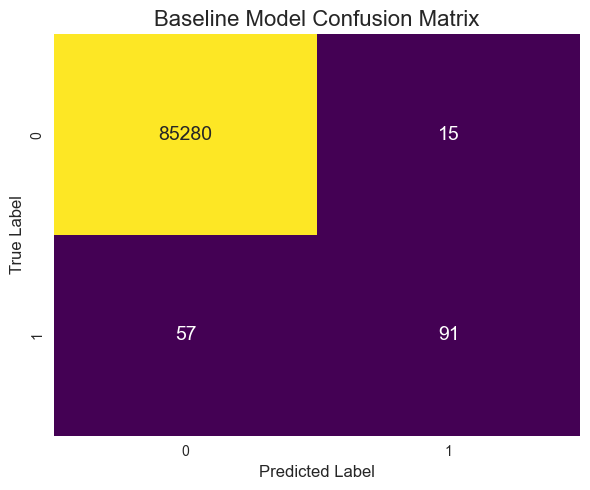

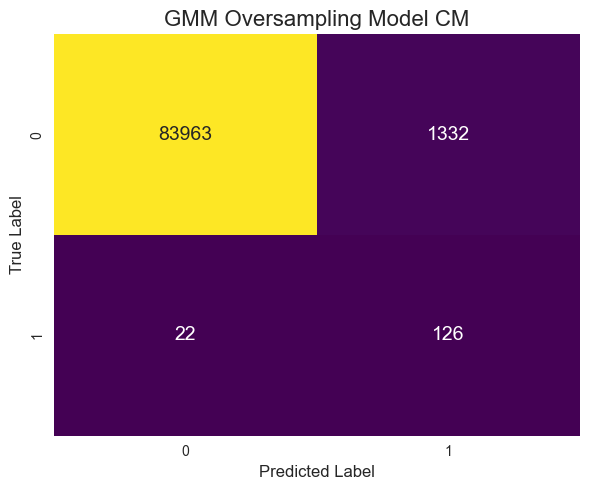

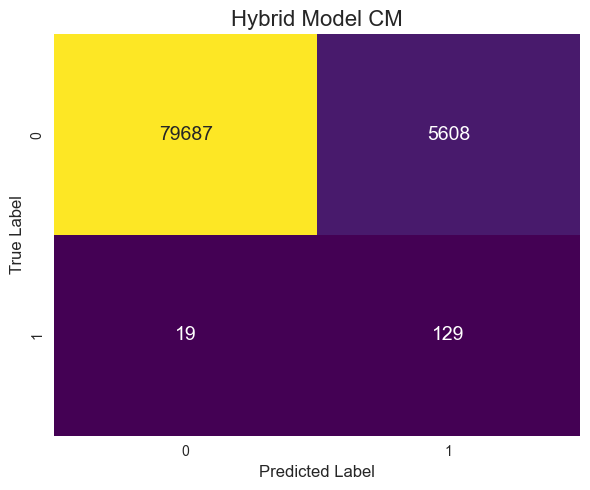

In [20]:
# Generate Confusion Matrices
cm_baseline = confusion_matrix(y_test, y_pred_baseline)
cm_oversample = confusion_matrix(y_test, y_pred_oversample)
cm_hybrid_adv = confusion_matrix(y_test, y_pred_hybrid_adv)

#  Plot 1: Bar Chart for Metric Comparison
plt.figure(figsize=(10, 7))
ax = comparison_df.T.plot(kind='bar', figsize=(10,7), colormap='viridis', rot=0)
plt.title('Model Performance Comparison for the Minority (Fraud) Class', fontsize=16)
plt.ylabel('Score', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.ylim(0, 1.05)
# Add annotations to the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 9), textcoords='offset points')
plt.tight_layout()
plt.show()


# Plot 2: Confusion Matrix for Baseline Model (Individual Plot) 
plt.figure(figsize=(6, 5))
sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='viridis', cbar=False, annot_kws={"size": 14})
plt.title('Baseline Model Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()


# Plot 3: Confusion Matrix for GMM Oversampling Model
plt.figure(figsize=(6, 5))
sns.heatmap(cm_oversample, annot=True, fmt='d', cmap='viridis', cbar=False, annot_kws={"size": 14})
plt.title('GMM Oversampling Model CM', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()


# Plot 4: Confusion Matrix for Advanced Hybrid Model
plt.figure(figsize=(6, 5))
sns.heatmap(cm_hybrid_adv, annot=True, fmt='d', cmap='viridis', cbar=False, annot_kws={"size": 14})
plt.title('Hybrid Model CM', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()

The primary objective of employing a data augmentation strategy was to enhance the model's ability to detect the minority (fraudulent) class. An examination of the performance metrics confirms that the GMM-based techniques were highly successful in achieving this objective.

- The Baseline Model, as in the summary table, has a Recall of 61.5%. While its Precision was high at 85.8%, the recall figure indicates a significant failure rate, as the model was unable to identify nearly 39% of the fraudulent transactions in the test set. The corresponding confusion matrix confirms this, showing a large number of false negatives, which represents direct financial risk.
- The GMM-enhanced models demonstrated a dramatic improvement in recall. The GMM Oversampling model achieved a recall of 85.1%, while the Hybrid (CBU + GMM) model reached 88.5%. This increase says that the classifier, when trained on the synthetically balanced data, became far more sensitive and effective at identifying fraudulent instances.

**Precision Recall Tradeoff**
This however, also came with a heavy drop in precision. The precision for the GMM Oversampling and Hybrid models plummeted to 8.6% and 2.1%, respectively. Such low precision values render a model operationally unviable. It indicates that for every 100 transactions flagged as fraudulent by the hybrid model, approximately 92/98 would be false alarms.

The confusion matrices for the GMM-enhanced models visually adds this finding, showing a very low number of false negatives but an exceptionally high number of false positives


### Final Recommendation

**Maximising Objective Standpoint**

This particular context is a case where it is better for a model to be doubtful and suspicious rather than confident and wrong. Context like this and even in healthcare, where flagging a fraud case as legitimate is a much bigger problem than flagging some normal cases as fraud, the first priority is fraud detection. The operational use case becomes a secondary measure, as long as it is able to flag all these cases well. 

In this case, the Gaussian Mixture Models are a highly effective tool for synthetic data generation in the context of fraud detection, and their use is recommended. The GMM-based oversampling pipeline combined with the CBU undersampling, despite its apparent drawbacks in certain metrics, successfully addresses the most critical challenge of this problem and demonstrates a powerful capability that justifies its use. 

The baseline model's recall of ~61% is operationally unacceptable, as it implies that nearly 40% of fraudulent activities go undetected. The GMM-based models achieved a recall of ~86-89%, a monumental improvement. This demonstrates that the GMM-based approach successfully taught the classifier to identify the minority class with high sensitivity. In a domain where a single missed fraudulent transaction can cost thousands, this dramatic reduction in false negatives is the most significant indicator of success.

This recall imporvement is not just emperical, but is grounded in it's functioning. While doing clustering, we saw that the variance in the minority class had to be explained by more than 1 cluster. This shows that there various distinct patterns, which is what a GMM is explicitly designed to model. It can identify and learn these different fraudulent behaviors from the limited data available. It generates synthetic samples that are not just generic averages but are representative of the diverse and complex nature of real-world fraud. The GMM also learns the underlying probability distribution of the minority class. As a result, it can generate brand new, high-quality synthetic samples that are statistically consistent with the original data but are not simple copies or linear interpolations. 

In this example, the majority data is a huge number and has a lot of redundant patterns, thus the CBU undersampling and equal dataset rebalancing helps the model focus equally on the positives and negatives, increasing the recall more. 

**Operationally Viable Standpoint**

While Gaussian Mixture Models are a theoretically powerful tool for generating synthetic data, the specific sampling strategy of creating a perfectly balanced (1:1 ratio) dataset is not effective and is not recommended for this context. The resulting models, despite their high recall, are impractical for real-world deployment due to very low precision.

The goal of improving minority class detection was achieved, as evidenced by the ~27 percentage point increase in recall for the hybrid model over the baseline. However, this came with a ~83 percentage point decrease in precision. The resulting F1-score, a more holistic measure of model performance, shows a decisive decline

*Theoritically*, The increase in recall shows GMM's strength in learning the underlying probability distribution of the data, including complex, multi-modal structures that characterizes different types of fraud.  By sampling from this learned distribution, it creates high-quality, realistic synthetic data points that effectively teach the classifier the features of the minority class.

However, a model trained in this artificially high-risk environment becomes calibrated to be extremely sensitive and suspicious. When deployed on a real-world dataset where fraud is exceedingly rare, this hyper-vigilance results in the model flagging a vast number of legitimate transactions that have even a remote resemblance to the fraudulent patterns it studied so intensely


## Additional Analysis

**Sensitivity to n_components in GMM**

Our choice of k= 5 for the number of GMM components was based on the BIC/AIC scores. But how much does this choice actually affect the final classifier's performance? 

We will loop through k values from 2 to 10. For each k, we will generate a balanced dataset, train a Logistic Regression model, and evaluate its F1-Score, Area Under the Precision-Recall Curve (AUPRC) and Recall. 


Testing GMM with k=2...
Testing GMM with k=3...
Testing GMM with k=4...
Testing GMM with k=5...
Testing GMM with k=6...
Testing GMM with k=7...
Testing GMM with k=8...
Testing GMM with k=9...
Testing GMM with k=10...


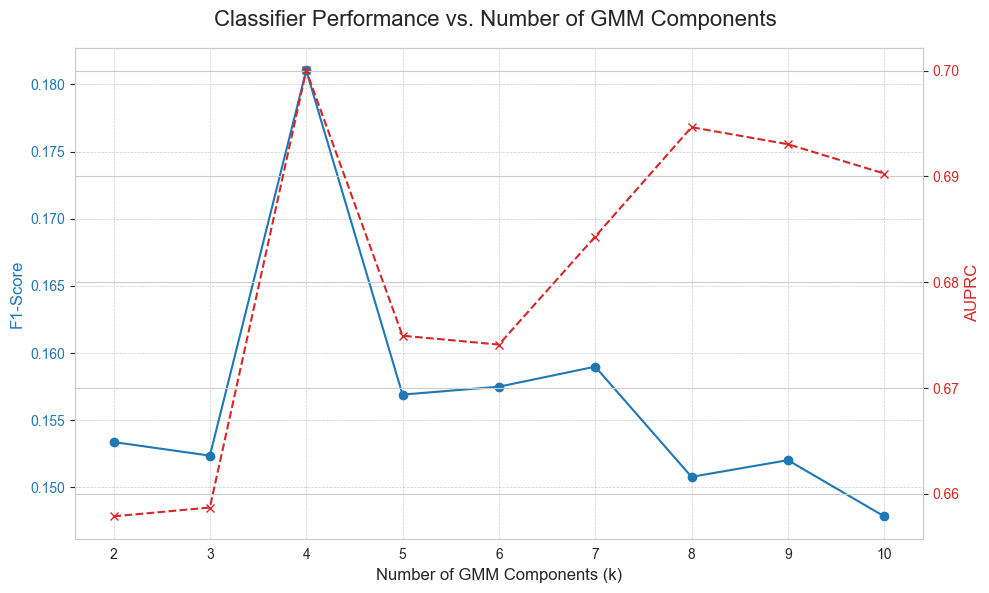

In [21]:
import warnings
warnings.filterwarnings('ignore')

k_values = range(2, 11)
f1_scores = []
auprc_scores = []
recall_scores = []

n_synthetic = n_majority - n_minority

for k in k_values:
    print(f"Testing GMM with k={k}...")
    # 1. Train GMM
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(X_train_minority)
    
    # 2. Generate synthetic samples
    X_synthetic, _ = gmm.sample(n_samples=n_synthetic)
    y_synthetic = np.ones(n_synthetic, dtype=int)
    
    # 3. Create balanced dataset
    X_train_bal = np.vstack((X_train_scaled.values, X_synthetic))
    y_train_bal = np.hstack((y_train.values, y_synthetic))
    
    # 4. Train classifier
    model = LogisticRegression(random_state=42, max_iter=1000)
    model.fit(X_train_bal, y_train_bal)
    
    # 5. Evaluate
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1] # Probabilities for the positive class
    
    f1_scores.append(f1_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))
    auprc_scores.append(average_precision_score(y_test, y_pred_proba))

# Plot the results
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot F1 scores
color = 'tab:blue'
ax1.set_xlabel('Number of GMM Components (k)', fontsize=12)
ax1.set_ylabel('F1-Score', color=color, fontsize=12)
ax1.plot(k_values, f1_scores, color=color, marker='o', label='F1-Score')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

# Create a second y-axis for AUPRC scores
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('AUPRC', color=color, fontsize=12)
ax2.plot(k_values, auprc_scores, color=color, marker='x', linestyle='--', label='AUPRC')
ax2.tick_params(axis='y', labelcolor=color)

fig.suptitle('Classifier Performance vs. Number of GMM Components', fontsize=16)
fig.tight_layout()
plt.show()

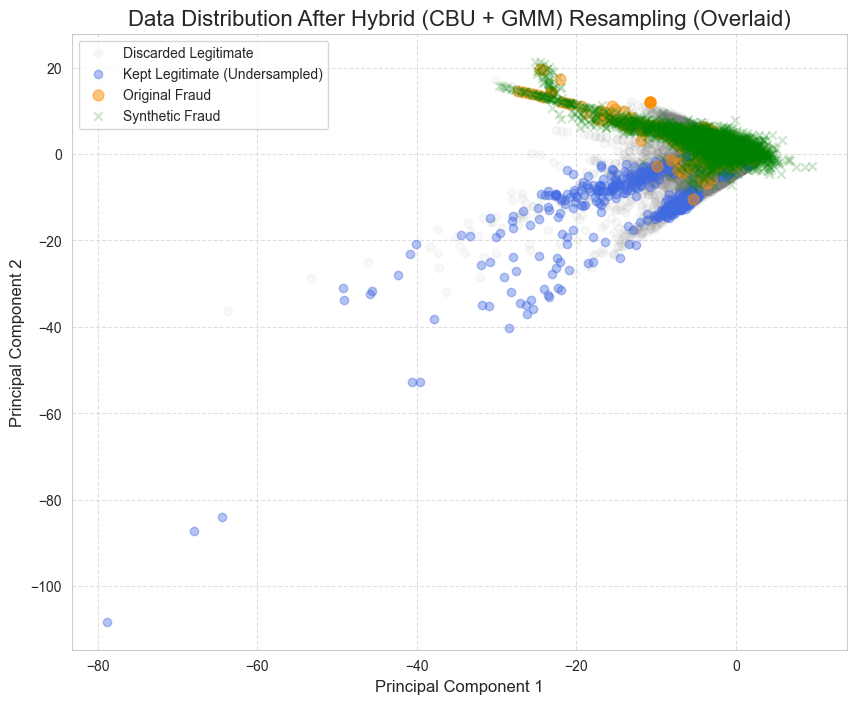

In [28]:
# --- OVERLAID PLOT: BEFORE & AFTER HYBRID (CBU + GMM) RESAMPLING ---

# To ensure a consistent 2D projection, we fit PCA on the ENTIRE original training set
pca_hybrid = PCA(n_components=2, random_state=RANDOM_STATE)
pca_hybrid.fit(X_train_scaled)

# Find the indices of the majority points that were kept vs. discarded
original_majority_indices = X_train_majority.index
undersampled_indices_set = set(X_train_majority_undersampled.index)
discarded_indices = [idx for idx in original_majority_indices if idx not in undersampled_indices_set]

# Get the data for the discarded points
X_train_majority_discarded = X_train_scaled.loc[discarded_indices]

# Now, TRANSFORM all the different data segments using the SAME fitted PCA
X_maj_discarded_pca = pca_hybrid.transform(X_train_majority_discarded)
X_maj_undersampled_pca = pca_hybrid.transform(X_train_majority_undersampled)
X_min_original_pca = pca_hybrid.transform(X_train_minority)
X_min_synthetic_pca = pca_hybrid.transform(X_synthetic_hybrid)


# Create a single scatter plot with all components
plt.figure(figsize=(10, 8))
plt.title('Data Distribution After Hybrid (CBU + GMM) Resampling (Overlaid)', fontsize=16)

# Plot Discarded Majority points first as a faint background
plt.scatter(X_maj_discarded_pca[:, 0], X_maj_discarded_pca[:, 1], 
            label='Discarded Legitimate', alpha=0.05, color='gray')

# Plot Undersampled (Kept) Majority points
plt.scatter(X_maj_undersampled_pca[:, 0], X_maj_undersampled_pca[:, 1], 
            label='Kept Legitimate (Undersampled)', alpha=0.4, color='royalblue')

# Plot Original Minority points
plt.scatter(X_min_original_pca[:, 0], X_min_original_pca[:, 1], 
            label='Original Fraud', alpha=0.5, color='darkorange', s=60)

# Plot Synthetic Minority points
plt.scatter(X_min_synthetic_pca[:, 0], X_min_synthetic_pca[:, 1], 
            label='Synthetic Fraud', alpha=0.2, color='green', marker='x')


plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()